In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
# from datetime import datetime
# import numpy as np
# import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
from sklearn.model_selection import train_test_split
import scipy


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe

In [3]:
from fbprophet import Prophet

In [118]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('../Merilytics/incident_response_data/incident_event_log.csv')


In [5]:
df.head()

number incident_state  active  reassignment_count  reopen_count  \
0  INC0000045            New    True                   0             0   
1  INC0000045       Resolved    True                   0             0   
2  INC0000045       Resolved    True                   0             0   
3  INC0000045         Closed   False                   0             0   
4  INC0000047            New    True                   0             0   

   sys_mod_count  made_sla    caller_id       opened_by        opened_at  ...  \
0              0      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
1              2      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
2              3      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
3              4      True  Caller 2403    Opened by  8  29/2/2016 01:16  ...   
4              0      True  Caller 2403  Opened by  397  29/2/2016 04:40  ...   

  u_priority_confirmation         notify problem_id rfc vendor caused_by  \
0                   False  Do Not Notify          ?   ?      ?         ?   
1                   False  Do Not Notify          ?   ?      ?         ?   
2                   False  Do Not Notify          ?   ?      ?         ?   
3                   False  Do Not Notify          ?   ?      ?         ?   
4                   False  Do Not Notify          ?   ?      ?         ?   

  closed_code      resolved_by      resolved_at       closed_at  
0      code 5  Resolved by 149  29/2/2016 11:29  5/3/2016 12:00  
1      code 5  Resolved by 149  29/2/2016 11:29  5/3/2016 12:00  
2      code 5  Resolved by 149  29/2/2016 11:29  5/3/2016 12:00  
3      code 5  Resolved by 149  29/2/2016 11:29  5/3/2016 12:00  
4      code 5   Resolved by 81   1/3/2016 09:52  6/3/2016 10:00  

[5 rows x 36 columns]

In [6]:
df.describe()

reassignment_count   reopen_count  sys_mod_count
count       119998.000000  119998.000000  119998.000000
mean             1.151236       0.021025       5.199312
std              1.782823       0.196173       7.804628
min              0.000000       0.000000       0.000000
25%              0.000000       0.000000       1.000000
50%              1.000000       0.000000       3.000000
75%              2.000000       0.000000       7.000000
max             27.000000       8.000000     129.000000

In [7]:
df.shape

(119998, 36)

In [8]:
columns = df.columns

In [9]:
df.replace('?', np.nan, inplace=True)

In [10]:
df.isna().sum()

number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
opened_at                       0
sys_created_by              42354
sys_created_at              42354
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       64
subcategory                    97
u_symptom                   28271
cmdb_ci                    119562
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 23030
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 118061
rfc           

In [11]:
def basic_data(column):
    print('nunique: ', column.nunique())
    print('\nunique: ', column.unique())
    print('\nNull values: ', column.isna().sum())

In [12]:
columns_to_change_to_datetime = ['closed_at', 'opened_at' ]

for i in columns_to_change_to_datetime:
    df[i] = df[i].astype('datetime64[ns]')

In [13]:
df.dtypes

number                             object
incident_state                     object
active                               bool
reassignment_count                  int64
reopen_count                        int64
sys_mod_count                       int64
made_sla                             bool
caller_id                          object
opened_by                          object
opened_at                  datetime64[ns]
sys_created_by                     object
sys_created_at                     object
sys_updated_by                     object
sys_updated_at                     object
contact_type                       object
location                           object
category                           object
subcategory                        object
u_symptom                          object
cmdb_ci                            object
impact                             object
urgency                            object
priority                           object
assignment_group                  

In [14]:
# life of a ticket in seconds
df['ticket_life'] = (df['closed_at'] - df['opened_at']).dt.total_seconds()

In [15]:
# tickets opened after closing
# Filtering out the rows where the opened_at > closed_at

negative_life = df[df.ticket_life<0 ]
negative_life.shape

(46336, 37)

In [16]:
perc = negative_life.shape[0]/df.shape[0]*100
perc

38.613976899615

In [17]:
negative_life.head()

number incident_state  active  reassignment_count  reopen_count  \
489  INC0000174            New    True                   0             0   
490  INC0000174            New    True                   0             0   
491  INC0000174            New    True                   0             0   
492  INC0000174            New    True                   1             0   
493  INC0000174            New    True                   1             0   

     sys_mod_count  made_sla    caller_id       opened_by           opened_at  \
489              0      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
490              3      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
491              4      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
492              6      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
493              7      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   

     ...         notify problem_id  rfc vendor caused_by closed_code  \
489  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
490  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
491  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
492  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
493  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   

         resolved_by     resolved_at           closed_at ticket_life  
489  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
490  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
491  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
492  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
493  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  

[5 rows x 37 columns]

In [18]:
# tickets with negative life
negative_life[negative_life['reopen_count']<1].head()

number incident_state  active  reassignment_count  reopen_count  \
489  INC0000174            New    True                   0             0   
490  INC0000174            New    True                   0             0   
491  INC0000174            New    True                   0             0   
492  INC0000174            New    True                   1             0   
493  INC0000174            New    True                   1             0   

     sys_mod_count  made_sla    caller_id       opened_by           opened_at  \
489              0      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
490              3      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
491              4      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
492              6      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   
493              7      True  Caller 4414  Opened by  131 2016-02-29 10:39:00   

     ...         notify problem_id  rfc vendor caused_by closed_code  \
489  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
490  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
491  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
492  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   
493  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 1   

         resolved_by     resolved_at           closed_at ticket_life  
489  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
490  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
491  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
492  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  
493  Resolved by 184  2/3/2016 13:01 2016-02-03 13:02:00  -2237820.0  

[5 rows x 37 columns]

In [19]:
# total tickets with negative life and reopen count = 0
negative_life[negative_life['reopen_count']<1].shape

(45621, 37)

In [20]:
negative_life[negative_life.reassignment_count > 1].shape

(12161, 37)

In [21]:
df[df.reassignment_count<1].shape

(57377, 37)

In [22]:
len(df.number)

119998

In [23]:
df.number.nunique()

20769

In [24]:
df.groupby(by='number').get_group(df.number[0])

number incident_state  active  reassignment_count  reopen_count  \
0  INC0000045            New    True                   0             0   
1  INC0000045       Resolved    True                   0             0   
2  INC0000045       Resolved    True                   0             0   
3  INC0000045         Closed   False                   0             0   

   sys_mod_count  made_sla    caller_id     opened_by           opened_at  \
0              0      True  Caller 2403  Opened by  8 2016-02-29 01:16:00   
1              2      True  Caller 2403  Opened by  8 2016-02-29 01:16:00   
2              3      True  Caller 2403  Opened by  8 2016-02-29 01:16:00   
3              4      True  Caller 2403  Opened by  8 2016-02-29 01:16:00   

   ...         notify problem_id  rfc vendor caused_by closed_code  \
0  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 5   
1  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 5   
2  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 5   
3  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 5   

       resolved_by      resolved_at           closed_at ticket_life  
0  Resolved by 149  29/2/2016 11:29 2016-05-03 12:00:00   5568240.0  
1  Resolved by 149  29/2/2016 11:29 2016-05-03 12:00:00   5568240.0  
2  Resolved by 149  29/2/2016 11:29 2016-05-03 12:00:00   5568240.0  
3  Resolved by 149  29/2/2016 11:29 2016-05-03 12:00:00   5568240.0  

[4 rows x 37 columns]

In [25]:
df = df[df.ticket_life>0]

In [26]:
df.shape

(73662, 37)

In [27]:
df.sample()

number incident_state  active  reassignment_count  reopen_count  \
4243  INC0001075       Resolved    True                   1             0   

      sys_mod_count  made_sla    caller_id      opened_by           opened_at  \
4243             10      True  Caller 3204  Opened by  24 2016-02-03 09:48:00   

      ...         notify problem_id  rfc vendor caused_by closed_code  \
4243  ...  Do Not Notify        NaN  NaN    NaN       NaN      code 5   

          resolved_by     resolved_at           closed_at ticket_life  
4243  Resolved by 227  7/3/2016 10:22 2016-03-24 18:40:00   4351920.0  

[1 rows x 37 columns]

In [28]:
print('percentage of missing values'.upper())
df.isna().sum()/df.shape[0]*100

PERCENTAGE OF MISSING VALUES


number                      0.000000
incident_state              0.000000
active                      0.000000
reassignment_count          0.000000
reopen_count                0.000000
sys_mod_count               0.000000
made_sla                    0.000000
caller_id                   0.021721
opened_by                   4.375390
opened_at                   0.000000
sys_created_by             35.104939
sys_created_at             35.104939
sys_updated_by              0.000000
sys_updated_at              0.000000
contact_type                0.000000
location                    0.066520
category                    0.069235
subcategory                 0.095029
u_symptom                  21.107219
cmdb_ci                    99.674188
impact                      0.000000
urgency                     0.000000
priority                    0.000000
assignment_group           11.856860
assigned_to                17.521924
knowledge                   0.000000
u_priority_confirmation     0.000000
n

In [29]:
drop = ['caused_by', 'rfc', 'vendor','cmdb_ci','problem_id']
df.drop(drop,axis=1,inplace=True)

In [30]:
df.shape

(73662, 32)

In [31]:
temp = df[['opened_at', 'sys_created_at']]
temp = temp.dropna().astype('datetime64[ns]')

In [32]:
temp['gap'] = temp.sys_created_at - temp.opened_at

In [33]:
import datetime
temp_mean = temp[temp.gap > datetime.timedelta(hours=0,minutes=0,seconds=0)].gap.mean()
temp_mean

Timedelta('0 days 00:09:52.656746788')

In [34]:
# df['sys_created_at'].fillna(value=(df.opened_at+temp_mean)).mean()
from datetime import timedelta

df['sys_created + temp_mean'] = df.opened_at + timedelta(minutes = 9, seconds=52.656746788)

In [35]:
df.sys_created_at.fillna(value = df['sys_created + temp_mean'],inplace=True)

In [36]:
temp2 = df[['opened_at', 'resolved_at']]

In [37]:
temp2a = temp2.dropna()

In [38]:
temp2a.resolved_at = temp2a.resolved_at.astype('datetime64[ns]')

C:\Users\gprak\anaconda3\envs\my36v2\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
temp2a['new'] = temp2a.resolved_at - temp2a.opened_at

C:\Users\gprak\anaconda3\envs\my36v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
temp2a.new.mean()

Timedelta('33 days 00:09:27.862276449')

In [41]:
import datetime
df['new2'] = df['opened_at'] + datetime.timedelta(days=5,hours = 5, minutes=34, seconds=59.468314879)

In [42]:
df['resolved_at'].fillna(value = df.new2,inplace=True)

In [43]:
df.isna().sum()

number                         0
incident_state                 0
active                         0
reassignment_count             0
reopen_count                   0
sys_mod_count                  0
made_sla                       0
caller_id                     16
opened_by                   3223
opened_at                      0
sys_created_by             25859
sys_created_at                 0
sys_updated_by                 0
sys_updated_at                 0
contact_type                   0
location                      49
category                      51
subcategory                   70
u_symptom                  15548
impact                         0
urgency                        0
priority                       0
assignment_group            8734
assigned_to                12907
knowledge                      0
u_priority_confirmation        0
notify                         0
closed_code                  305
resolved_by                  111
resolved_at                    0
closed_at 

In [44]:
# creating a neww class for missing values  for caller id
df['caller_id'].fillna(value='caller 4340',inplace=True)

# creating a neww class for missing values for opened by
df['opened_by'].fillna(value = 'Opened by 4341', inplace=True)

# creating a neww class for missing values for sys created by
df['sys_created_by'].fillna(value='Created by 4342', inplace=True)

# creating a neww class for missing values for location
df['location'].fillna('Location 4343', inplace=True)

# creating a neww class for missing values for category
df['category'].fillna('Category 4344',inplace=True)

# creating a neww class for missing values for subcategory
df['subcategory'].fillna(value='Subcategory 4345',inplace=True)

# creating a neww class for missing values for symptoms
df['u_symptom'].fillna(value='Symptom 4346', inplace=True)

# creating a neww class for missing values for assignment group
df['assignment_group'].fillna(value='Group 4347',inplace=True)

# creating a neww class for missing values for resolver
df['assigned_to'].fillna(value='Resolver 4348',inplace=True)

# creating a neww class for missing values for problem id
# df['problem_id'].fillna(value='Promlem ID 4349',inplace=True)

In [45]:
# replacing with mode
df['closed_code'].fillna(df['closed_code'].mode()[0],inplace=True)
df['resolved_by'].fillna(df['resolved_by'].mode()[0],inplace=True)

In [46]:
df.isna().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
closed_code                0
resolved_by                0
resolved_at                0
closed_at                  0
ticket_life                0
sys_created + temp_mean    0
new2                       0
dtype: int64

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le

LabelEncoder()

In [48]:
columns_to_be_label_encoded = ['active',
                         'made_sla',
                         'contact_type',
                         'knowledge',
                         'u_priority_confirmation',
                         'notify',
                         'incident_state',
                         'caller_id',
                         'opened_by',
                         'sys_created_by',
                         'sys_updated_by',
                         'location',
                         'category',
                         'subcategory',
                         'u_symptom',
                         'assignment_group',
                         'assigned_to',
                         'closed_code',
                         'resolved_by',
                         'number']

In [49]:
for i in columns_to_be_label_encoded:
    df[i] = le.fit_transform(df[i])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(i.upper(),'\n', le_name_mapping)
    print('*'*150)

ACTIVE 
 {False: 0, True: 1}
******************************************************************************************************************************************************
MADE_SLA 
 {False: 0, True: 1}
******************************************************************************************************************************************************
CONTACT_TYPE 
 {'Email': 0, 'Phone': 1}
******************************************************************************************************************************************************
KNOWLEDGE 
 {False: 0, True: 1}
******************************************************************************************************************************************************
U_PRIORITY_CONFIRMATION 
 {False: 0, True: 1}
******************************************************************************************************************************************************
NOTIFY 
 {'Do Not Notify': 0, 'Send Email': 1}
********************

LOCATION 
 {'Location 100': 0, 'Location 101': 1, 'Location 102': 2, 'Location 107': 3, 'Location 108': 4, 'Location 109': 5, 'Location 11': 6, 'Location 110': 7, 'Location 111': 8, 'Location 112': 9, 'Location 113': 10, 'Location 114': 11, 'Location 115': 12, 'Location 117': 13, 'Location 118': 14, 'Location 12': 15, 'Location 120': 16, 'Location 121': 17, 'Location 124': 18, 'Location 125': 19, 'Location 128': 20, 'Location 129': 21, 'Location 13': 22, 'Location 131': 23, 'Location 133': 24, 'Location 135': 25, 'Location 136': 26, 'Location 137': 27, 'Location 14': 28, 'Location 140': 29, 'Location 141': 30, 'Location 142': 31, 'Location 143': 32, 'Location 144': 33, 'Location 147': 34, 'Location 148': 35, 'Location 149': 36, 'Location 15': 37, 'Location 153': 38, 'Location 155': 39, 'Location 157': 40, 'Location 158': 41, 'Location 160': 42, 'Location 161': 43, 'Location 162': 44, 'Location 165': 45, 'Location 166': 46, 'Location 167': 47, 'Location 169': 48, 'Location 17': 49, 'Loc

RESOLVED_BY 
 {'Resolved by 100': 0, 'Resolved by 101': 1, 'Resolved by 102': 2, 'Resolved by 103': 3, 'Resolved by 104': 4, 'Resolved by 105': 5, 'Resolved by 106': 6, 'Resolved by 107': 7, 'Resolved by 108': 8, 'Resolved by 109': 9, 'Resolved by 11': 10, 'Resolved by 111': 11, 'Resolved by 112': 12, 'Resolved by 113': 13, 'Resolved by 114': 14, 'Resolved by 115': 15, 'Resolved by 116': 16, 'Resolved by 117': 17, 'Resolved by 118': 18, 'Resolved by 119': 19, 'Resolved by 120': 20, 'Resolved by 121': 21, 'Resolved by 122': 22, 'Resolved by 123': 23, 'Resolved by 124': 24, 'Resolved by 125': 25, 'Resolved by 126': 26, 'Resolved by 127': 27, 'Resolved by 128': 28, 'Resolved by 129': 29, 'Resolved by 13': 30, 'Resolved by 130': 31, 'Resolved by 131': 32, 'Resolved by 132': 33, 'Resolved by 133': 34, 'Resolved by 134': 35, 'Resolved by 135': 36, 'Resolved by 136': 37, 'Resolved by 137': 38, 'Resolved by 138': 39, 'Resolved by 139': 40, 'Resolved by 140': 41, 'Resolved by 142': 42, 'Resolve

In [50]:
columns_to_be_ordinal_encoded = ['impact','urgency','priority']
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

for i in columns_to_be_ordinal_encoded:
    df[i] = oe.fit_transform(df[i].values.reshape(-1,1))
#     le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#     print(i, le_name_mapping)

In [51]:
df.dtypes

number                              int32
incident_state                      int32
active                              int64
reassignment_count                  int64
reopen_count                        int64
sys_mod_count                       int64
made_sla                            int64
caller_id                           int32
opened_by                           int32
opened_at                  datetime64[ns]
sys_created_by                      int32
sys_created_at                     object
sys_updated_by                      int32
sys_updated_at                     object
contact_type                        int32
location                            int32
category                            int32
subcategory                         int32
u_symptom                           int32
impact                            float64
urgency                           float64
priority                          float64
assignment_group                    int32
assigned_to                       

In [52]:
columns_for_obj_to_datetime = ['sys_created_at',
                              'sys_updated_at',
                              'resolved_at']

In [53]:
for i in columns_for_obj_to_datetime:
    df[i] = df[i].astype('datetime64[ns]')

In [54]:
df.dtypes

number                              int32
incident_state                      int32
active                              int64
reassignment_count                  int64
reopen_count                        int64
sys_mod_count                       int64
made_sla                            int64
caller_id                           int32
opened_by                           int32
opened_at                  datetime64[ns]
sys_created_by                      int32
sys_created_at             datetime64[ns]
sys_updated_by                      int32
sys_updated_at             datetime64[ns]
contact_type                        int32
location                            int32
category                            int32
subcategory                         int32
u_symptom                           int32
impact                            float64
urgency                           float64
priority                          float64
assignment_group                    int32
assigned_to                       

In [55]:
import matplotlib.pyplot as plt



In [56]:

rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(10, 10))
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [57]:
#import seaborn

In [58]:
# seaborn.pairplot(df)
# plt.show()

In [59]:
df['timestamp'] = pd.to_datetime(df['opened_at'])

In [60]:
df2=df

In [61]:
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape

(8103, 28)

In [62]:
#express to plot entire data
fig = px.line(df.reset_index(), x='timestamp', y='impact', title='Demand')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig.show()

In [63]:

taxi_df = df.reset_index()[['timestamp', 'impact']].rename({'timestamp':'ds', 'impact':'y'}, axis='columns')
taxi_df.dropna(inplace=True)

In [64]:
taxi_df.head()

ds    y
0 2016-01-03 01:00:00  1.0
1 2016-01-03 02:00:00  1.0
2 2016-01-03 03:00:00  1.0
4 2016-01-03 05:00:00  1.0
5 2016-01-03 06:00:00  1.0

In [65]:
print(taxi_df.head)

<bound method NDFrame.head of                       ds    y
0    2016-01-03 01:00:00  1.0
1    2016-01-03 02:00:00  1.0
2    2016-01-03 03:00:00  1.0
4    2016-01-03 05:00:00  1.0
5    2016-01-03 06:00:00  1.0
...                  ...  ...
7378 2016-11-05 11:00:00  1.0
8039 2016-12-03 00:00:00  1.0
8050 2016-12-03 11:00:00  1.0
8071 2016-12-04 08:00:00  1.0
8102 2016-12-05 15:00:00  1.0

[1175 rows x 2 columns]>


In [66]:
taxi_df.shape

(1175, 2)

In [67]:
train = taxi_df[(taxi_df['ds'] >= '2016-01-03') & (taxi_df['ds'] <= '2016-10-03')]
test = taxi_df[(taxi_df['ds'] > '2016-10-03')]

In [68]:
train.shape

(1154, 2)

In [69]:
test.shape

(21, 2)

In [70]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [71]:
future = m.make_future_dataframe(periods=119, freq='H')

In [72]:
future.tail(4)

ds
1269 2016-09-10 12:00:00
1270 2016-09-10 13:00:00
1271 2016-09-10 14:00:00
1272 2016-09-10 15:00:00

In [73]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1268 2016-09-10 11:00:00  1.001899    0.781120    1.230572
1269 2016-09-10 12:00:00  0.991876    0.769048    1.224179
1270 2016-09-10 13:00:00  0.985901    0.762833    1.220483
1271 2016-09-10 14:00:00  0.985838    0.762771    1.204097
1272 2016-09-10 15:00:00  0.984665    0.763263    1.200325

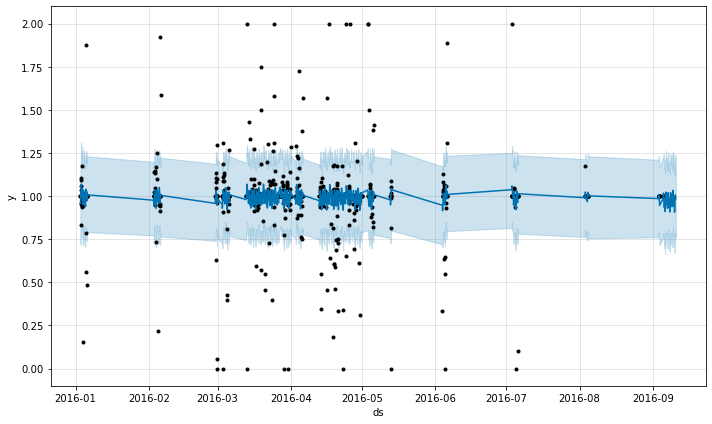

In [74]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

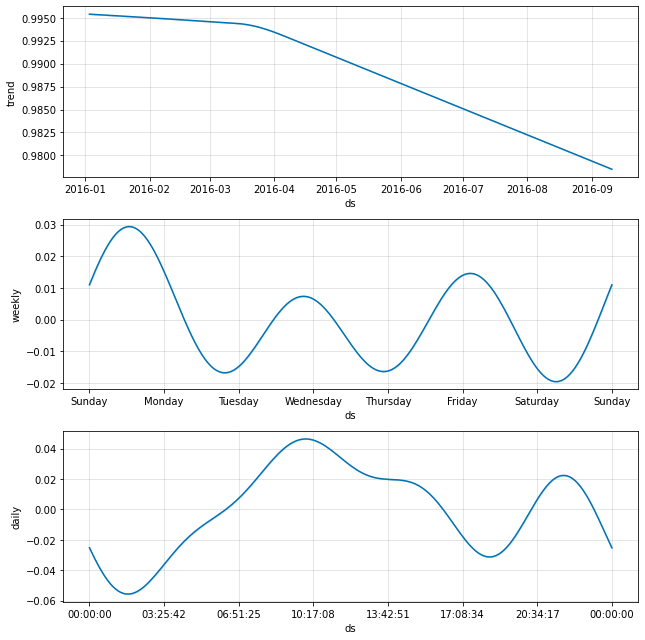

In [75]:
comp = m.plot_components(forecast)

In [76]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [77]:
result[result['error'].abs()>1.5*result['uncertainty']]

y      yhat  yhat_lower  yhat_upper     error  \
ds                                                                          
2016-01-04 03:00:00  0.153846  0.959975    0.725440    1.189194 -0.806129   
2016-01-05 14:00:00  1.875000  1.018362    0.777389    1.234539  0.856638   
2016-02-04 21:00:00  0.217391  1.021795    0.804205    1.244487 -0.804404   
2016-02-05 21:00:00  1.925000  0.999215    0.781597    1.226865  0.925785   
2016-02-29 20:00:00  0.000000  0.970421    0.757006    1.187929 -0.970421   
2016-02-29 22:00:00  0.055556  1.000186    0.784137    1.220822 -0.944631   
2016-03-03 06:00:00  0.000000  0.980256    0.748129    1.191504 -0.980256   
2016-03-13 06:00:00  2.000000  1.015251    0.786699    1.236149  0.984749   
2016-03-13 07:00:00  0.000000  1.028854    0.810159    1.254406 -1.028854   
2016-03-19 11:00:00  1.750000  1.017617    0.778835    1.255471  0.732383   
2016-03-24 23:00:00  2.000000  1.012265    0.777581    1.235007  0.987735   
2016-03-29 00:00:00  0.000000  0.953629    0.727100    1.163337 -0.953629   
2016-03-30 19:00:00  0.000000  0.950985    0.723351    1.181390 -0.950985   
2016-04-04 06:00:00  1.727273  0.991510    0.752321    1.202482  0.735763   
2016-04-17 01:00:00  2.000000  0.955820    0.736388    1.187663  1.044180   
2016-04-18 21:00:00  0.184211  0.990457    0.766357    1.223632 -0.806246   
2016-04-23 05:00:00  0.000000  0.959179    0.751137    1.170183 -0.959179   
2016-04-24 09:00:00  2.000000  1.059619    0.823453    1.280479  0.940381   
2016-04-25 23:00:00  2.000000  0.980508    0.751220    1.199786  1.019492   
2016-05-03 11:00:00  2.000000  1.030263    0.802514    1.278452  0.969737   
2016-05-03 12:00:00  2.000000  1.020296    0.783409    1.223976  0.979704   
2016-05-13 04:00:00  0.000000  0.977534    0.754248    1.203919 -0.977534   
2016-06-05 00:00:00  0.000000  0.973255    0.746483    1.204398 -0.973255   
2016-06-05 22:00:00  1.888889  1.028553    0.808708    1.247904  0.860335   
2016-07-03 08:00:00  2.000000  1.037012    0.815339    1.250716  0.962988   
2016-07-05 01:00:00  0.000000  0.921244    0.682799    1.144540 -0.921244   
2016-07-05 19:00:00  0.100000  0.964393    0.722268    1.181096 -0.864393   

                     uncertainty  
ds                                
2016-01-04 03:00:00     0.463754  
2016-01-05 14:00:00     0.457149  
2016-02-04 21:00:00     0.440282  
2016-02-05 21:00:00     0.445268  
2016-02-29 20:00:00     0.430924  
2016-02-29 22:00:00     0.436686  
2016-03-03 06:00:00     0.443375  
2016-03-13 06:00:00     0.449449  
2016-03-13 07:00:00     0.444247  
2016-03-19 11:00:00     0.476636  
2016-03-24 23:00:00     0.457427  
2016-03-29 00:00:00     0.436237  
2016-03-30 19:00:00     0.458039  
2016-04-04 06:00:00     0.450161  
2016-04-17 01:00:00     0.451275  
2016-04-18 21:00:00     0.457275  
2016-04-23 05:00:00     0.419046  
2016-04-24 09:00:00     0.457026  
2016-04-25 23:00:00     0.448566  
2016-05-03 11:00:00     0.475938  
2016-05-03 12:00:00     0.440567  
2016-05-13 04:00:00     0.449672  
2016-06-05 00:00:00     0.457916  
2016-06-05 22:00:00     0.439196  
2016-07-03 08:00:00     0.435377  
2016-07-05 01:00:00     0.461742  
2016-07-05 19:00:00     0.458828

In [78]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [79]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

In [80]:
#df['opened_at']=pd.to_datetime(data['opened_at'])
#data['closed_at']=pd.to_datetime(data['closed_at'])

data = df2
data['Difference'] = (data['closed_at'] - data['opened_at']).dt.days
data['Difference'] = np.array(data['Difference'])

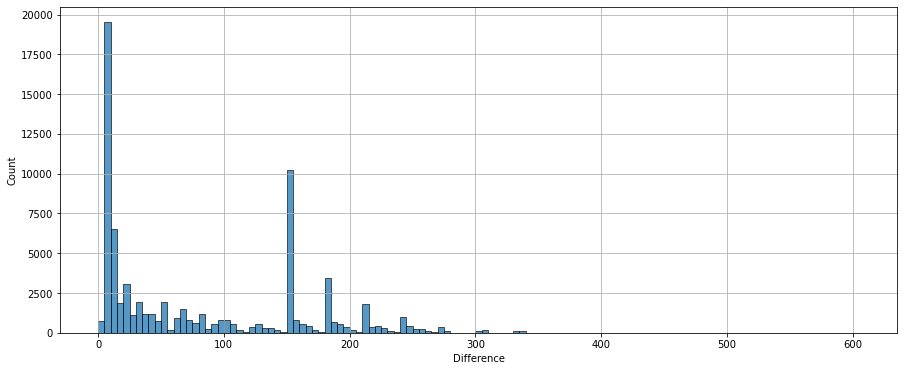

In [81]:
# Lets see the distribution of this dependent variable that we have created
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot((data['Difference']),binwidth=5)
plt.grid()
plt.show()

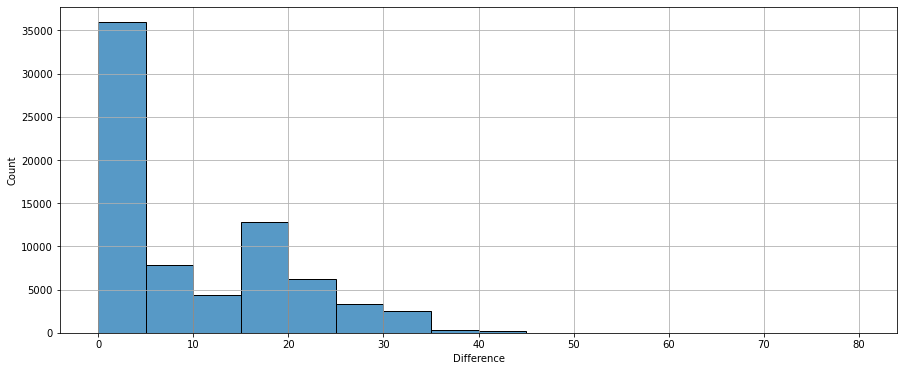

In [82]:
# Lets see the distribution of this dependent variable that we have created
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(np.abs((data['Difference'])/8),binwidth=5)
plt.grid()
plt.show()

In [83]:
np.sort(np.abs((data['Difference'])/8).astype(int).unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 41, 43, 53, 60, 63, 65, 69, 75])

In [84]:
data['Difference'] = np.abs((data['Difference'])/8).astype(int)

In [85]:
def cut(arr):
    bins = np.empty(arr.shape[0])
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 5):
            bins[idx] = 1
        elif (x >= 5) & (x < 11):
            bins[idx] = 2
        elif (x >= 11) & (x < 21):
            bins[idx] = 3
        elif (x >= 21) & (x < 31):
            bins[idx] = 4
        else:
            bins[idx] = 5
    return bins

In [86]:
data['Target'] = np.array(cut(data['Difference']))

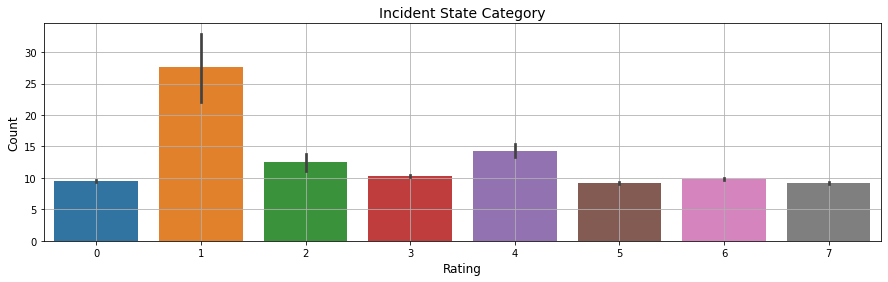

In [87]:
# incident_state
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'incident_state',y='Difference',ax=ax)
plt.title("Incident State Category", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()


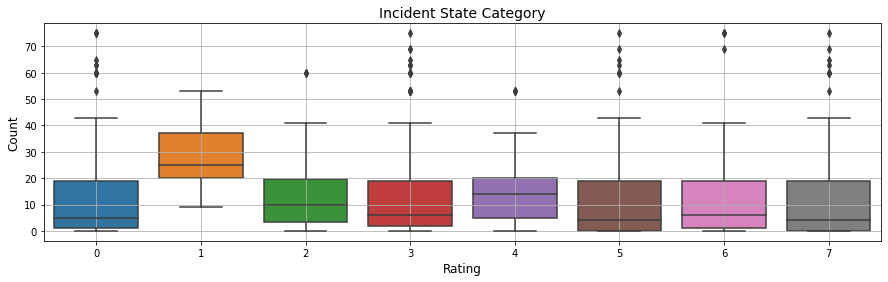

In [88]:
# incident_state
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'incident_state',y='Difference',ax=ax)
plt.title("Incident State Category", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

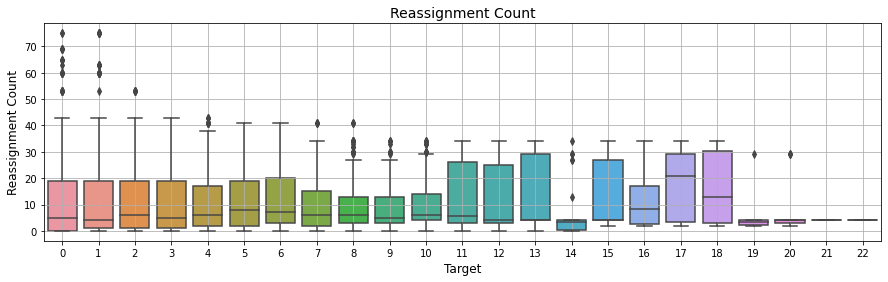

In [89]:
# reassignment_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'reassignment_count',y='Difference',ax=ax)
plt.title("Reassignment Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

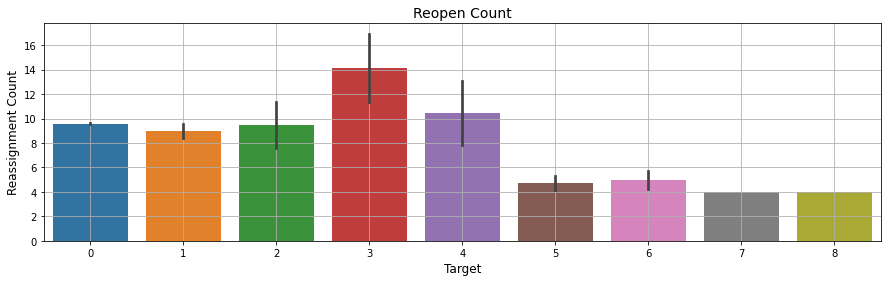

In [90]:
# reopen_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'reopen_count',y='Difference',ax=ax)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

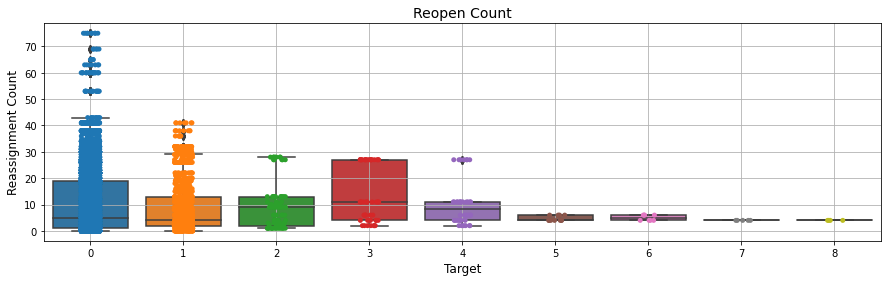

In [91]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,y= 'Difference',x='reopen_count',ax=ax)
sns.stripplot(data=data,y= 'Difference',x='reopen_count',ax=ax,jitter=True)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

C:\Users\gprak\anaconda3\envs\my36v2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



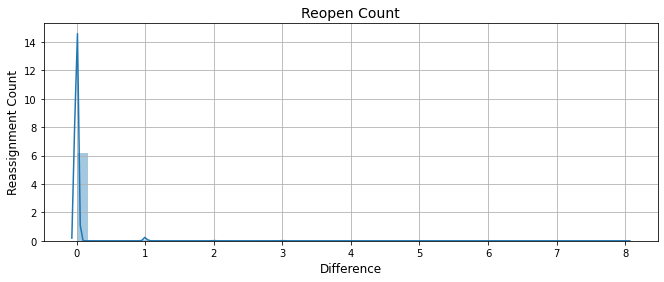

In [92]:
fig_dims = (11, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(data['reopen_count'])
plt.title("Reopen Count", size = 14)
plt.xlabel("Difference", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

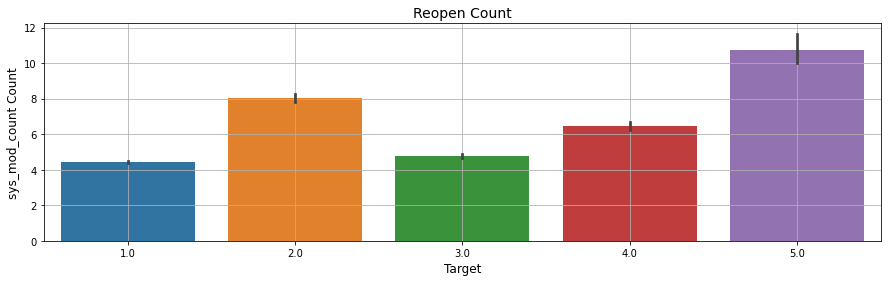

In [93]:
# sys_mod_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'Target',y='sys_mod_count',ax=ax)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("sys_mod_count Count", size=12)
plt.grid()
plt.show()

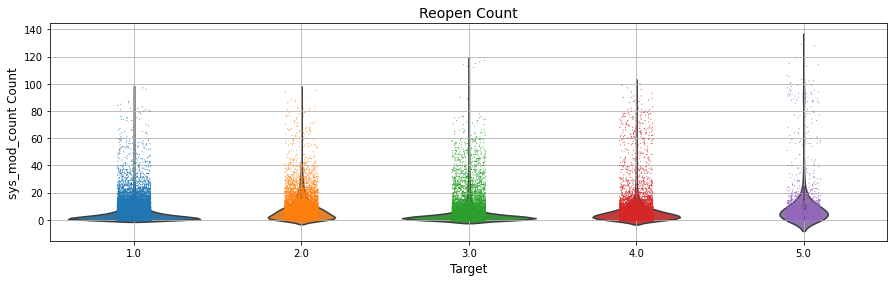

In [94]:
# sys_mod_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot(data=data,x= 'Target',y='sys_mod_count',ax=ax)
sns.stripplot(data=data,y= 'sys_mod_count',x='Target',ax=ax,jitter=True,size=1)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("sys_mod_count Count", size=12)
plt.grid()
plt.show()

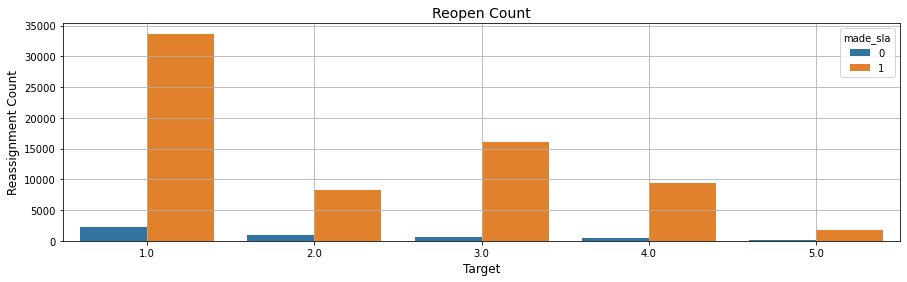

In [95]:
# made_sla
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data,x='Target',ax=ax,hue='made_sla')
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

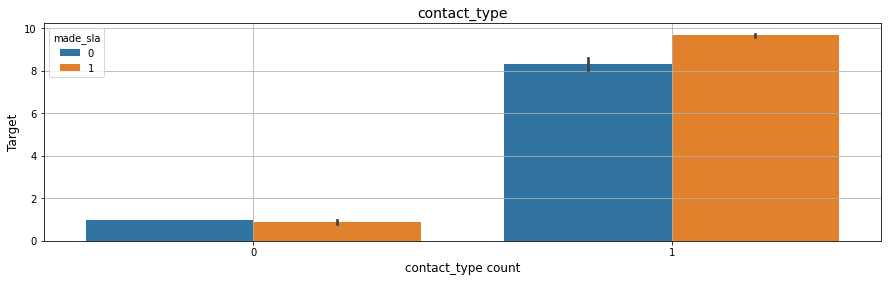

1    73592
0       70
Name: contact_type, dtype: int64

In [96]:
# contact_type
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'contact_type',y='Difference',ax=ax,hue='made_sla')
plt.title("contact_type", size = 14)
plt.xlabel("contact_type count", size=12)
plt.ylabel("Target", size=12)
plt.grid()
plt.show()
data.contact_type.value_counts()

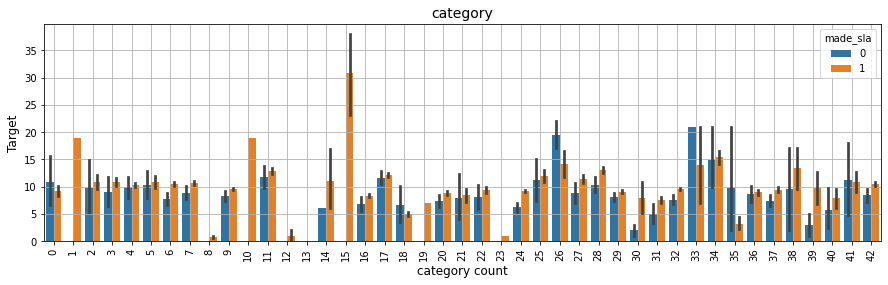

In [97]:
# category
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'category',y='Difference',ax=ax,hue='made_sla')
plt.title("category", size = 14)
plt.xlabel("category count", size=12)
plt.ylabel("Target", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

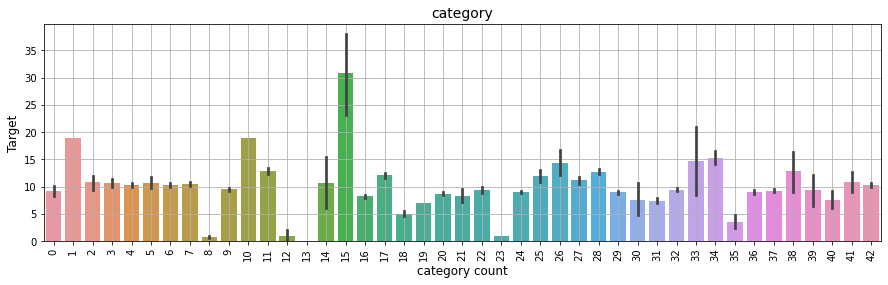

In [98]:
# category
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'category',y='Difference',ax=ax)#,hue='made_sla')
plt.title("category", size = 14)
plt.xlabel("category count", size=12)
plt.ylabel("Target", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

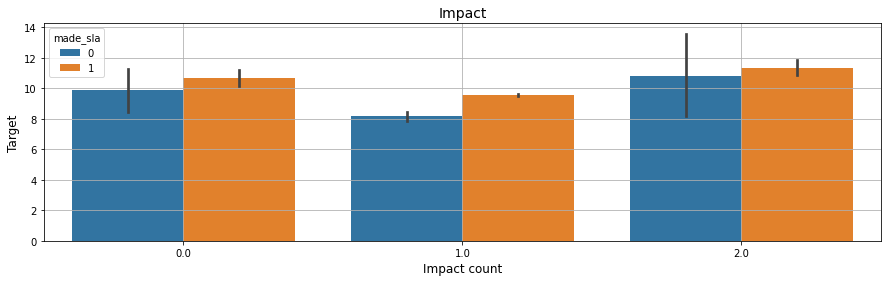

In [99]:
# impact
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'impact',y='Difference',ax=ax,hue='made_sla')
plt.title("Impact", size = 14)
plt.xlabel("Impact count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

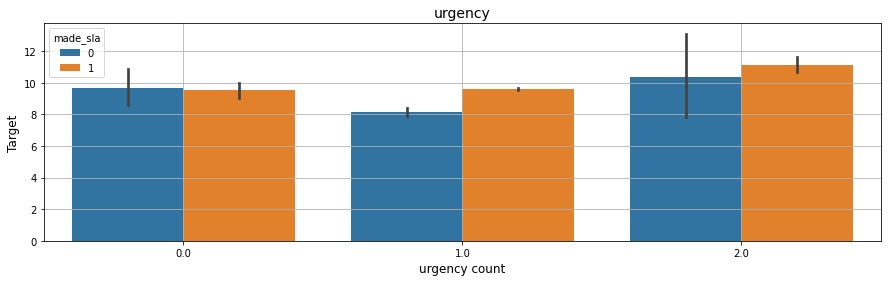

In [100]:
# urgency
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'urgency',y='Difference',ax=ax,hue='made_sla')
plt.title("urgency", size = 14)
plt.xlabel("urgency count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

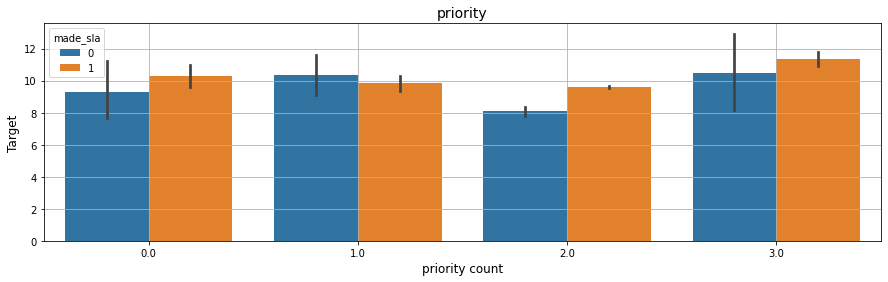

In [101]:
# priority
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'priority',y='Difference',ax=ax,hue='made_sla')
plt.title("priority", size = 14)
plt.xlabel("priority count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

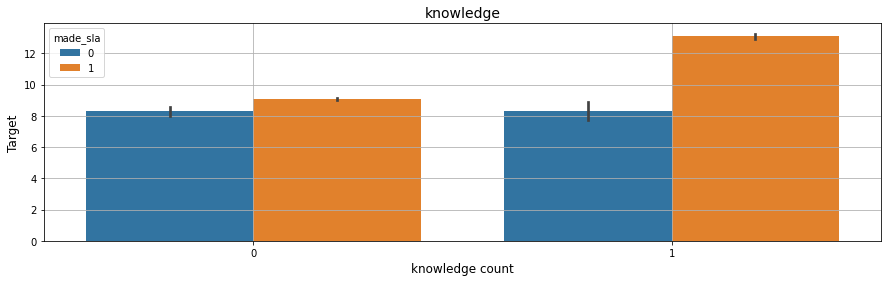

In [102]:
# 'knowledge'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'knowledge',y='Difference',ax=ax,hue='made_sla')
plt.title("knowledge", size = 14)
plt.xlabel("knowledge count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

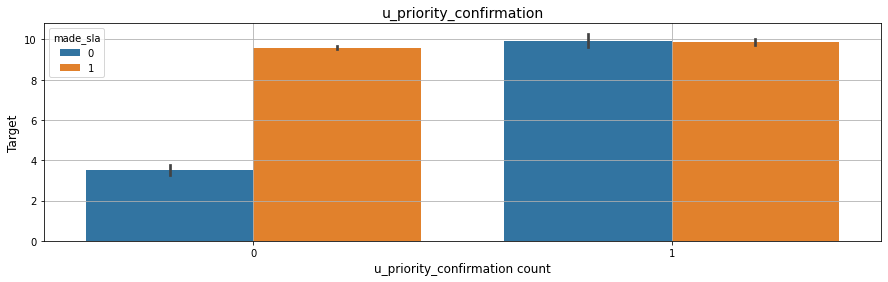

In [103]:
# 'u_priority_confirmation'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'u_priority_confirmation',y='Difference',ax=ax,hue='made_sla')
plt.title("u_priority_confirmation", size = 14)
plt.xlabel("u_priority_confirmation count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()


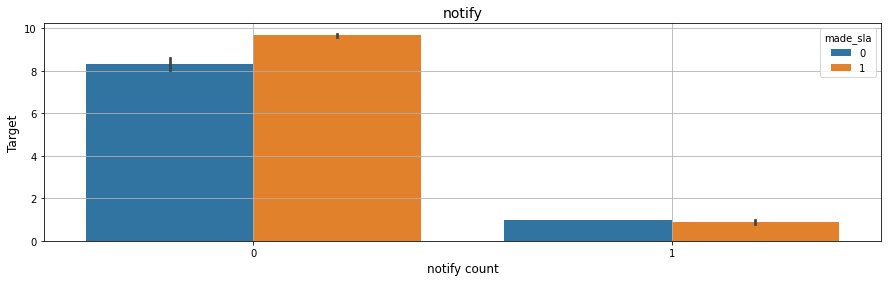

In [104]:
# 'notify'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'notify',y='Difference',ax=ax,hue='made_sla')
plt.title("notify", size = 14)
plt.xlabel("notify count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()
    

In [105]:
# Removing Outliers 
cols = ['Difference'] # one or more

Q1 = data[cols].quantile(0.1)
Q3 = data[cols].quantile(0.9)
IQR = Q3 - Q1

data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group',
       'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at', 'ticket_life',
       'sys_created + temp_mean', 'new2', 'timestamp', 'Difference', 'Target'],
      dtype='object')

In [106]:
categorical_feature = ['incident_state', 'active', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify']
num_feat = ['reassignment_count', 'reopen_count','sys_mod_count']

In [107]:
# OneHotEncoding for all the categorical feature
enc = OneHotEncoder(handle_unknown='ignore')
cat_spar = enc.fit_transform(data[categorical_feature])

In [108]:
scaler = StandardScaler()
num_feat = scaler.fit_transform(data[num_feat])

In [109]:
def pandas_to_sparse(mat1,mat2): # Returns combines sparse matrix
    mat2 = csr_matrix(mat2)
    print("End of Sparse Matrix\n")
    return hstack([mat1,mat2])

In [110]:
data_sparse = pandas_to_sparse(cat_spar,num_feat)

End of Sparse Matrix



In [111]:
from sklearn.decomposition import TruncatedSVD

In [112]:
#print(data.dtypes)
#print(list(data.columns))
#X = data.drop('Target')
X=data[['number', 'incident_state', 'active', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify', 'closed_code', 'resolved_by', 
         'ticket_life', 'Difference']]
y = data['Target']
print(X.dtypes)

number                       int32
incident_state               int32
active                       int64
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                     int64
caller_id                    int32
opened_by                    int32
sys_created_by               int32
sys_updated_by               int32
contact_type                 int32
location                     int32
category                     int32
subcategory                  int32
u_symptom                    int32
impact                     float64
urgency                    float64
priority                   float64
assignment_group             int32
assigned_to                  int32
knowledge                    int64
u_priority_confirmation      int64
notify                       int32
closed_code                  int32
resolved_by                  int32
ticket_life                float64
Difference                   int32
dtype: object


In [113]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(data_sparse, y, test_size=0.33, random_state=42)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [115]:
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=4)
# perform the search
model.fit(X_train, y_train)
# summarize performance
acc = model.score(X_test, y_test)
print("Accuracy: %.3f" % acc)
# summarize the best model
print(model.best_model())

  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.081375 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 50%|██████████████████████████████████████                                      | 1/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.073520 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000000


 67%|██████████████████████████████████████████████████▋                         | 2/3 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.242379 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000000


 75%|█████████████████████████████████████████████████████████                   | 3/4 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.083242 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000000


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00, 29.96s/trial, best loss: 0.0]
Accuracy: 1.000
{'learner': ExtraTreesClassifier(bootstrap=True, max_features=0.9096605500707855,
                     n_estimators=291, n_jobs=1, random_state=1, verbose=False), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


In [125]:
def validate_result(y_test,y_pred):
    predicted_labels = y_pred
    
    # Build the confusion matrix of our 3-class classification problem
    cnf_matrix = confusion_matrix(y_test, predicted_labels)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    
    my_dict={"FP":FP,
    "FN":FN,
    "TP":TP,
    "TN":TN,
             "TPR":TPR,"TNR":TNR,"PPV":PPV,"NPV":NPV,"FPR":FPR,
    "FNR":FNR,"FDR":FDR,"ACC":ACC
}
    return pd.DataFrame(my_dict)


In [127]:
metrics_df=validate_result(y_test,model.predict(X_test))

In [128]:
metrics_df

FP   FN       TP       TN  TPR  TNR  PPV  NPV  FPR  FNR  FDR  ACC
0  0.0  0.0  11889.0  12404.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0
1  0.0  0.0   2982.0  21311.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0
2  0.0  0.0   5509.0  18784.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0
3  0.0  0.0   3295.0  20998.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0
4  0.0  0.0    618.0  23675.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0